In [44]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import asyncio
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [45]:

api = wandb.Api()
entity, project = "ajzero", "AlphaZero"
x_metric = "planning_budget"
tags = ['2024-03-17-00-55-52', '2024-03-17-10-41-24']
filters = {"tags": {"$in": tags}}
runs = api.runs(entity + "/" + project, filters=filters)
runs

<Runs ajzero/AlphaZero>

In [46]:
# crete a dataframe from runs and summary metrics

data = []
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config
    summary.update(config)
    data.append(summary)

df = pd.DataFrame(data)

df


100%|██████████| 120/120 [00:00<00:00, 131.23it/s]


,Self_Play/Min_Return,Self_Play/Discounted_Return,Training/Value_Simularities,Self_Play/Max_Return,Training/Value_and_Policy_loss,grad_steps,Self_Play/Total_Timesteps,episodes,Training/Policy_loss,Self_Play/EMA_Return,...,policy_loss_weight,sample_batch_ratio,tree_value_transform,observation_embedding,regularization_weight,root_selection_policy,episodes_per_iteration,tree_evaluation_policy,replay_buffer_multiplier,selection_value_transform
0,0,"{'_type': 'histogram', 'bins': [0, 0.002345227...",0.673868,1,0.394845,58,206,180,1.304368,0.656277,...,0.3,1,identity,coordinate,0.0001,PolicyPUCT,6,mvc,10,identity
1,0,"{'_type': 'histogram', 'bins': [0, 9.941683674...",0.839212,1,0.388604,58,177,180,1.279780,0.495496,...,0.3,1,identity,coordinate,0.0001,PUCT,6,mvc,10,identity
2,0,"{'bins': [-0.5, -0.484375, -0.46875, -0.453125...",0.915120,0,0.407246,58,249,180,1.335501,0.020213,...,0.3,1,identity,coordinate,0.0001,PUCT,6,visit,10,identity
3,0,"{'_type': 'histogram', 'bins': [0, 7.028414188...",0.197440,1,0.422062,58,266,180,1.383690,0.050166,...,0.3,1,identity,coordinate,0.0001,PolicyPUCT,6,mvc,10,identity
4,0,"{'_type': 'histogram', 'bins': [-0.5, -0.48437...",0.832501,0,0.431340,58,196,180,1.383216,0.024984,...,0.3,1,identity,coordinate,0.0001,PUCT,6,mvc,10,identity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,18,"{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1...",0.147612,56,14.545679,232,228,180,0.447860,95.230133,...,0.3,1,identity,default,0.0001,PUCT,6,mvc,10,identity
116,133,"{'_type': 'histogram', 'values': [1, 0, 1, 0, ...",0.673523,300,116.804518,232,1319,180,0.506261,202.072651,...,0.3,1,identity,default,0.0001,PUCT,6,visit,10,identity
117,272,"{'_type': 'histogram', 'bins': [272, 272.4375,...",0.311178,300,17.696991,232,1772,180,0.413938,225.250406,...,0.3,1,identity,default,0.0001,PolicyPUCT,6,mvc,10,identity
118,98,"{'_type': 'histogram', 'values': [1, 0, 1, 0, ...",0.748630,162,13.332836,232,729,180,0.422038,106.500776,...,0.3,1,identity,default,0.0001,PUCT,6,mvc,10,identity


In [47]:
df.columns

Index(['Self_Play/Min_Return', 'Self_Play/Discounted_Return',
       'Training/Value_Simularities', 'Self_Play/Max_Return',
       'Training/Value_and_Policy_loss', 'grad_steps',
       'Self_Play/Total_Timesteps', 'episodes', 'Training/Policy_loss',
       'Self_Play/EMA_Return', 'Training/Replay_Buffer_Size', '_step',
       '_wandb', 'Self_Play/Mean_Discounted_Return', 'Self_Play/Timesteps',
       '_timestamp', 'Self_Play/Entropies', 'environment_steps',
       'Self_Play/Min_Timesteps', 'Self_Play/Mean_Entropy',
       'Self_Play/Mean_Timesteps', 'Self_Play/Returns',
       'Training/Regularization_loss', 'Training/Value_loss',
       'Training/Learning_Rate', 'Self_Play/Total_Mean_Return', '_runtime',
       'Self_Play/Mean_Return', 'Self_Play/Cumulative_Return', 'ncols',
       'layers', 'puct_c', 'workers', 'lr_gamma', 'dir_alpha', 'env_params',
       'eval_param', 'hidden_dim', 'iterations', 'model_type', 'norm_layer',
       'dir_epsilon', 'activation_fn', 'learning_rate', '

In [48]:
df.discount_factor.unique()

array([0.9, 1. ])

In [49]:
save_folder = 'outfiles'


def name_fn(name):
    # remove "Self_Play/" prefix if it exists
    if name.startswith("Self_Play/"):
        name = name[len("Self_Play/"):]

    # replace slash with underscore
    name = name.replace("/", "_")

    # change underscore to space
    name = name.replace("_", " ")
    return name

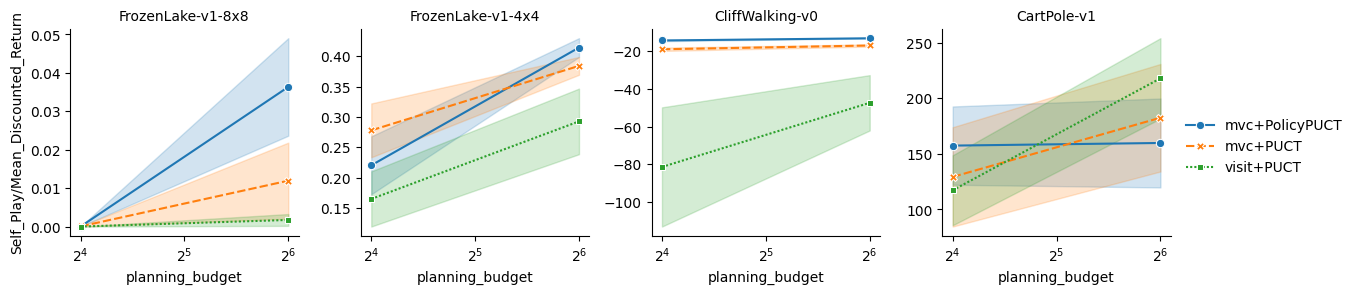

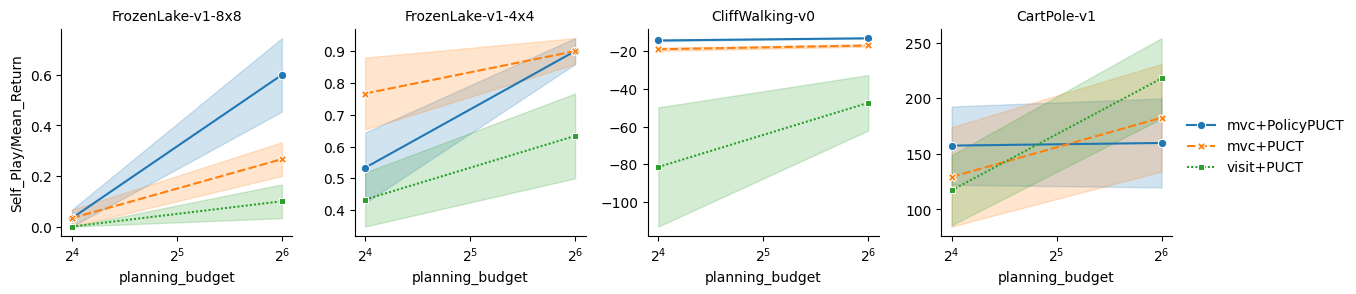

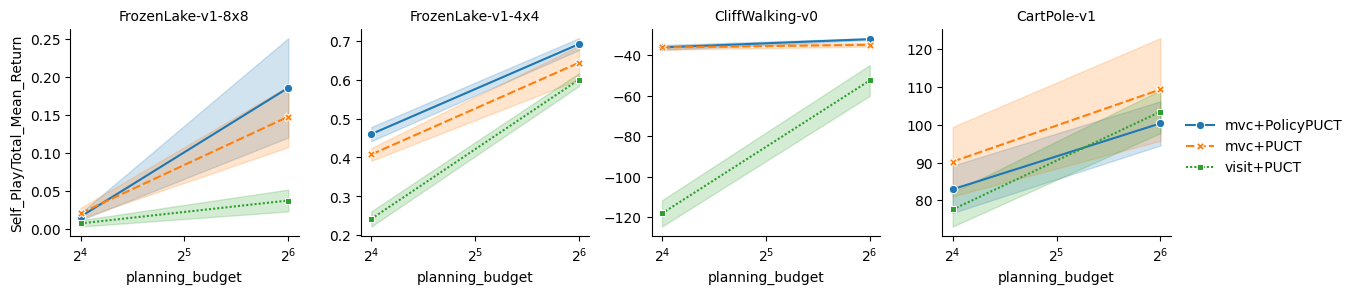

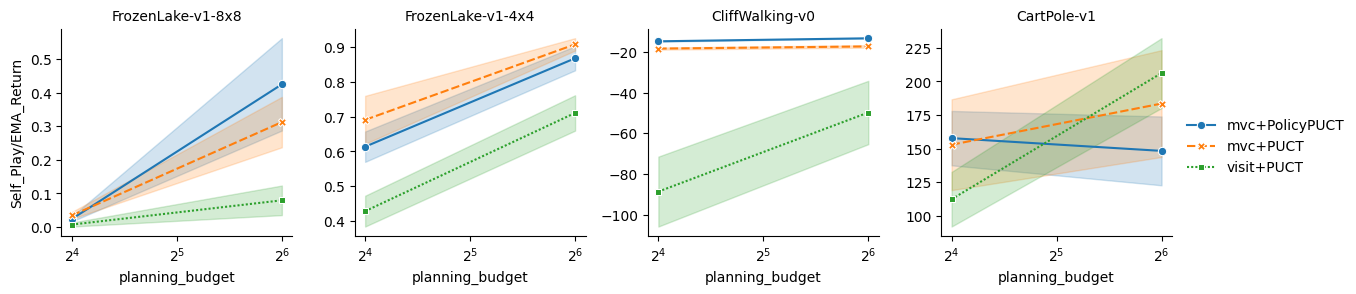

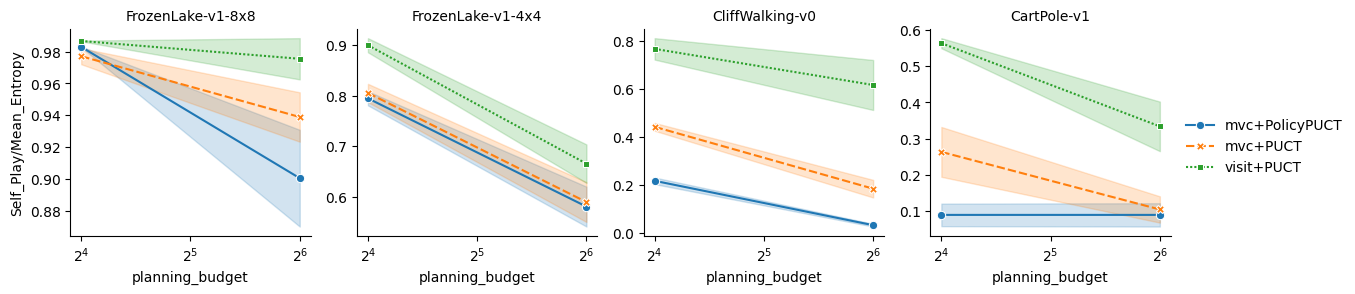

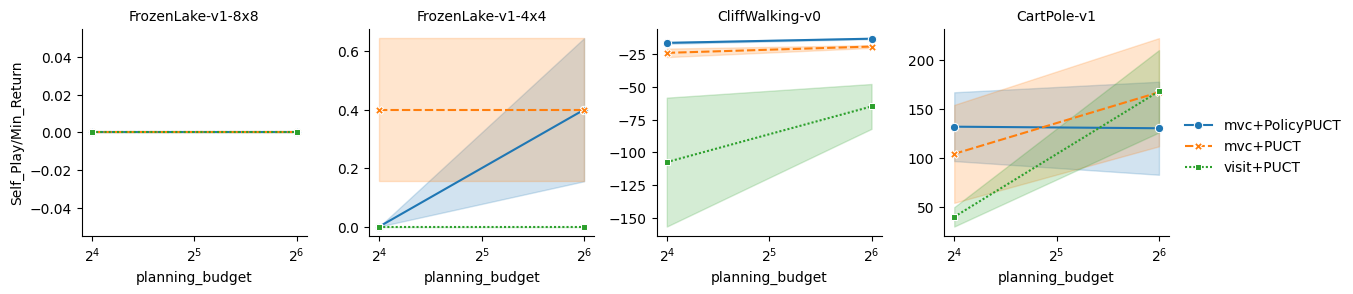

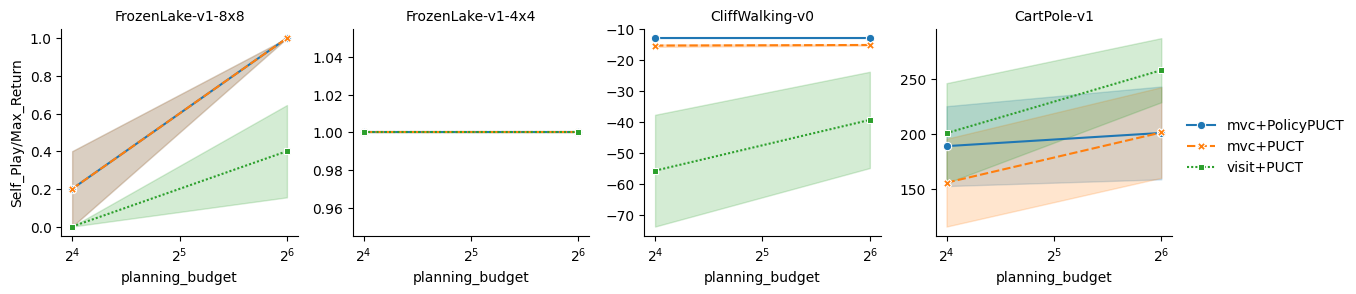

In [50]:



df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']

metrics = ['Self_Play/Mean_Discounted_Return','Self_Play/Mean_Return', "Self_Play/Total_Mean_Return", "Self_Play/EMA_Return", 'Self_Play/Mean_Entropy', 'Self_Play/Min_Return',
           'Self_Play/Max_Return',]


estimator = "mean"
for metric in metrics:
    # Step 1: Set up the FacetGrid to create one subplot for each unique value in 'env_description'
    # Note: adjust size and aspect to fit your data and preference
    g = sns.FacetGrid(df, col="env_description",sharex=True, sharey=False)

    # Step 2: Use map_dataframe to draw the lineplots on each subplot
    # Pass sns.lineplot as the plotting function and its arguments
    g.map_dataframe(sns.lineplot,
                    x=x_metric, y=metric,
                    hue="policy_combination", style="policy_combination",
                    markers=True, errorbar="se", estimator="mean")  # adjust 'estimator' as needed

    for ax in g.axes.flatten():
        ax.set_xscale('log', base=2)

    # Step 3: Adjusting aesthetics (optional)
    # Adding a legend
    g.add_legend()

    # Set the titles for each subplot for clarity
    g.set_titles("{col_name}")

    # Adjust the labels/titles as needed
    g.set_axis_labels(x_metric, metric)

    plt.show()